In [1]:
import sgkit_plink
import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
data_dir = Path('data/sim_01')
data_dir

PosixPath('data/sim_01')

In [3]:
variant_block_size = 100
sample_block_size = 50
alphas = np.array([1000.])

In [4]:
ds = sgkit_plink.read_plink(str(data_dir / 'genotypes'), bim_int_contig=True)
ds

<xarray.Dataset>
Dimensions:             (alleles: 2, ploidy: 2, samples: 250, variants: 1000)
Dimensions without coordinates: alleles, ploidy, samples, variants
Data variables:
    variant/contig      (variants) int16 dask.array<chunksize=(1000,), meta=np.ndarray>
    variant/position    (variants) int32 dask.array<chunksize=(1000,), meta=np.ndarray>
    variant/alleles     (variants, alleles) |S1 dask.array<chunksize=(1000, 1), meta=np.ndarray>
    sample/id           (samples) <U1 dask.array<chunksize=(250,), meta=np.ndarray>
    call/genotype       (variants, samples, ploidy) int8 dask.array<chunksize=(1000, 250, 2), meta=np.ndarray>
    call/genotype_mask  (variants, samples, ploidy) bool dask.array<chunksize=(1000, 250, 2), meta=np.ndarray>
    variant/id          (variants) <U1 dask.array<chunksize=(1000,), meta=np.ndarray>
    sample/family_id    (samples) <U1 dask.array<chunksize=(250,), meta=np.ndarray>
    sample/paternal_id  (samples) <U1 dask.array<chunksize=(250,), meta=np.ndarray>
    sample/maternal_id  (samples) <U1 dask.array<chunksize=(250,), meta=np.ndarray>
    sample/sex          (samples) int8 dask.array<chunksize=(250,), meta=np.ndarray>
    sample/phenotype    (samples) int8 dask.array<chunksize=(250,), meta=np.ndarray>
Attributes:
    contigs:  ['1']

In [5]:
ds['variant/position'].values[:50]

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50],
      dtype=int32)

In [6]:
ds['variant/alleles'].values[:5]

array([[b'C', b'A'],
       [b'C', b'A'],
       [b'C', b'A'],
       [b'C', b'A'],
       [b'C', b'A']], dtype='|S1')

In [7]:
ds['variant/id'].values[:5]

array(['1:1:A:C', '1:2:A:C', '1:3:A:C', '1:4:A:C', '1:5:A:C'],
      dtype='<U10')

In [8]:
contigs = ds['variant/contig'].values
pd.Series(contigs).value_counts()

1    1000
dtype: int64

In [9]:
G = ds['call/genotype'].sum(dim='ploidy').values
G.shape

(1000, 250)

In [10]:
G[:5, :5]

array([[1, 1, 2, 2, 2],
       [2, 0, 1, 2, 0],
       [1, 1, 0, 1, 2],
       [2, 0, 1, 2, 1],
       [2, 0, 1, 0, 1]])

In [11]:
df_cov = pd.read_csv(str(data_dir / 'covariates.csv'), index_col='sample_id')
df_cov = ((df_cov - df_cov.mean()) / df_cov.std(ddof=0))
df_cov.head()

,X000,X001,X002
sample_id,,,
S0000001,1.720448,0.460089,1.159124
S0000002,2.185960,1.908391,-0.855966
S0000003,0.925824,-0.084248,0.044491
S0000004,0.399152,0.207309,1.649021
S0000005,0.741265,0.185231,0.608095


In [12]:
X = df_cov.values
X.shape

(250, 3)

In [13]:
df_trait = pd.read_csv(str(data_dir / 'traits.csv'), index_col='sample_id')
df_trait = ((df_trait - df_trait.mean()) / df_trait.std(ddof=0))
df_trait.head()

,Y0000
sample_id,
S0000001,0.012737
S0000002,1.653571
S0000003,1.291104
S0000004,-0.243287
S0000005,0.711926


In [14]:
Y = df_trait.values
Y.shape

(250, 1)

In [43]:
from sgkit.stats import regenie
import imp
imp.reload(regenie)

<module 'sgkit.stats.regenie' from '/home/jovyan/work/repos/sgkit/sgkit/stats/regenie.py'>

In [44]:
res = regenie.regenie(G.T, X, Y, contigs, variant_block_size=variant_block_size, sample_block_size=sample_block_size, normalize=True, alphas=alphas)

In [45]:
# (n_variant_block, n_alpha, n_sample, n_outcome)
YP1 = res[0]
YP1

dask.array<stack, shape=(10, 1, 250, 1), dtype=float64, chunksize=(1, 1, 50, 1), chunktype=numpy.ndarray>

In [46]:
yp1 = YP1.compute()
yp1.shape

(10, 1, 250, 1)

In [47]:
np.allclose(yp1.mean(axis=2), 0)

False

In [48]:
np.allclose(yp1.std(axis=2), 1)

False

In [49]:
dfsg = (
    xr.DataArray(
        yp1, 
        dims=['variant_block_index', 'alpha_index', 'sample_index', 'outcome_index'], 
        name='sample_value'
    )
    .to_dataframe().reset_index()
)
dfsg

,variant_block_index,alpha_index,sample_index,outcome_index,sample_value
0,0,0,0,0,-0.053474
1,0,0,1,0,0.218910
2,0,0,2,0,0.219536
3,0,0,3,0,-0.255862
4,0,0,4,0,-0.180225
...,...,...,...,...,...
2495,9,0,245,0,-0.137656
2496,9,0,246,0,0.375567
2497,9,0,247,0,-0.421040
2498,9,0,248,0,-0.253960


In [50]:
import pandas as pd

def add_indexes(df):
    df['variant_block_index'] = df['header'].str.extract('block_(\d+)_').astype(int)
    df['sample_index'] = (df['sample_block'].astype(int) - 1) * df['size'] + df['sample_value_index'].astype(int)
    df['alpha_index'] = df['alpha'].str.extract('alpha_(\d+)').astype(int)
    df['outcome_index'] = df['label'].str.extract('Y(\d+)').astype(int)
    return df

dfgl = pd.read_parquet('result/glow/sim_01-v100-b50/reduced_blocks_flat.parquet')
dfgl = add_indexes(dfgl)
dfgl = dfgl.drop(['sample_value_index'], axis=1)
assert dfgl['sample_block'].nunique() == (G.shape[1] // sample_block_size)
assert dfgl['variant_block_index'].nunique() == (G.shape[0] // variant_block_size)
dfgl

,header,size,header_block,sample_block,sort_key,mu,sig,alpha,label,sample_value,variant_block_index,sample_index,alpha_index,outcome_index
0,chr_1_block_6_alpha_0_label_Y0000,50,chr_1,2,6,-0.039025,0.378516,alpha_0,Y0000,-0.214096,6,50,0,0
1,chr_1_block_6_alpha_0_label_Y0000,50,chr_1,2,6,-0.039025,0.378516,alpha_0,Y0000,-0.062973,6,51,0,0
2,chr_1_block_6_alpha_0_label_Y0000,50,chr_1,2,6,-0.039025,0.378516,alpha_0,Y0000,0.632400,6,52,0,0
3,chr_1_block_6_alpha_0_label_Y0000,50,chr_1,2,6,-0.039025,0.378516,alpha_0,Y0000,-0.421000,6,53,0,0
4,chr_1_block_6_alpha_0_label_Y0000,50,chr_1,2,6,-0.039025,0.378516,alpha_0,Y0000,0.438188,6,54,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,chr_1_block_5_alpha_0_label_Y0000,50,chr_1,3,5,0.021011,0.265918,alpha_0,Y0000,-0.101696,5,145,0,0
2496,chr_1_block_5_alpha_0_label_Y0000,50,chr_1,3,5,0.021011,0.265918,alpha_0,Y0000,0.253354,5,146,0,0
2497,chr_1_block_5_alpha_0_label_Y0000,50,chr_1,3,5,0.021011,0.265918,alpha_0,Y0000,-0.230217,5,147,0,0
2498,chr_1_block_5_alpha_0_label_Y0000,50,chr_1,3,5,0.021011,0.265918,alpha_0,Y0000,0.212285,5,148,0,0


In [51]:
dfsg.filter(regex='_index').describe().loc[['min', 'max']].astype(int).sort_index(axis=1)

,alpha_index,outcome_index,sample_index,variant_block_index
min,0,0,0,0
max,0,0,249,9


In [52]:
dfgl.filter(regex='_index').describe().loc[['min', 'max']].astype(int).sort_index(axis=1)

,alpha_index,outcome_index,sample_index,variant_block_index
min,0,0,0,0
max,0,0,249,9


In [53]:
cols = dfsg.filter(regex='_index').columns.tolist()
dfcomp = pd.concat([
    dfsg.set_index(cols)['sample_value'].rename('value_sgkit'),
    dfgl.set_index(cols)['sample_value'].rename('value_glow')
], axis=1, join='outer')
assert len(dfcomp.dropna()) == len(dfsg) == len(dfgl)
dfcomp.head()

value_sgkit  \
variant_block_index alpha_index sample_index outcome_index                
0                   0           0            0                -0.053474   
                                1            0                 0.218910   
                                2            0                 0.219536   
                                3            0                -0.255862   
                                4            0                -0.180225   

                                                            value_glow  
variant_block_index alpha_index sample_index outcome_index              
0                   0           0            0               -0.056585  
                                1            0                0.214959  
                                2            0                0.216297  
                                3            0               -0.258656  
                                4            0               -0.182779

In [54]:
dfcomp.describe()

,value_sgkit,value_glow
count,2500.000000,2500.000000
mean,-0.008324,-0.006590
std,0.295676,0.293981
min,-0.970640,-0.934239
25%,-0.206835,-0.204905
50%,-0.003953,-0.005911
75%,0.202214,0.201846
max,0.869551,0.891894


In [55]:
dfcomp.reset_index().groupby(['variant_block_index', 'sample_index'])['value_glow'].mean().describe()

count    2500.000000
mean       -0.006590
std         0.293981
min        -0.934239
25%        -0.204905
50%        -0.005911
75%         0.201846
max         0.891894
Name: value_glow, dtype: float64

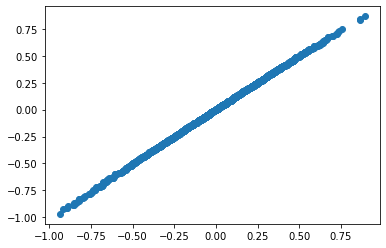

In [56]:
plt.scatter(dfcomp['value_glow'].sort_values().values, dfcomp['value_sgkit'].sort_values().values)

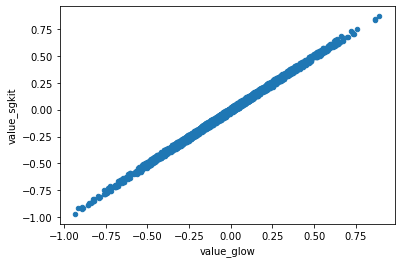

In [57]:
dfcomp.plot(kind='scatter', x='value_glow', y='value_sgkit')

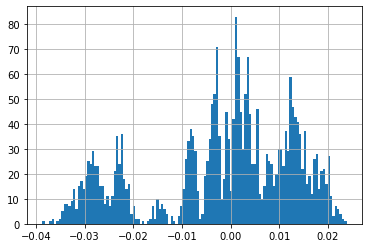

In [58]:
(dfcomp['value_sgkit'] - dfcomp['value_glow']).hist(bins=128)

In [59]:
dfcomp[np.isclose(dfcomp['value_sgkit'], dfcomp['value_glow'])]

,,,,value_sgkit,value_glow
variant_block_index,alpha_index,sample_index,outcome_index,,
3,0,200,0,0.107499,0.107498
